In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ipywidgets as widgets

from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis
from exp_analysis import gamma_heavy, gamma_heavy_integrated

In [3]:
physics_parameters['heavy']

{'m4_limits': (0.005, 1),
 'mz_limits': (0.005, 10),
 'm4_scan': [0.01, 0.1, 0.5],
 'mz_scan': [0.01, 0.1, 1, 5],
 'alpha_dark': 0.4,
 'Umu4': 2.2e-07,
 'espilon2': 0.00046,
 'alpha_em': 0.0072992700729927005,
 'span_2d': 9.945025,
 'Vmu4_alpha_epsilon2': 2.9547445255474454e-13}

In [93]:
case = 'heavy'
save_folder = ('../fig/control_checks/comparison_with_truth/' + case + '/')
!mkdir -p $save_folder
my_exp_analysis = exp_analysis(case)
my_exp_analysis.load_df_base(1000000)

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [91]:
def output_distrib(exp_analysis_obj, binning_in, bins, hist_range, range_other_variable, type_of_truth, material='lead'):  
    material_mask = my_exp_analysis.df_base[material, '']
    values_hist = my_exp_analysis.df_base[binning_in, ''].values
    hist_mask = (values_hist > hist_range[0]) &\
                (values_hist < hist_range[1])
    if binning_in == 'm4':
        other_variable = 'mzprime'
    elif binning_in == 'mzprime':
        other_variable = 'm4'
    other_variable_mask = (my_exp_analysis.df_base[other_variable, ''].values > range_other_variable[0]) &\
                          (my_exp_analysis.df_base[other_variable, ''].values < range_other_variable[1])
    weights = my_exp_analysis.df_base['weight_decay', ''].values/my_exp_analysis.df_base['mzprime', ''].values**4
    
    total_mask = material_mask & hist_mask & other_variable_mask
    
    bin_size = (hist_range[1] - hist_range[0])/bins * (range_other_variable[1] - range_other_variable[0])
    
    print(f'histogram_entries = {total_mask.sum()}')
    print(f'Total integral from vegas = {weights[total_mask].sum()}')
    
    bin_edges = np.linspace(*hist_range, bins+1)
    plt.hist(values_hist[total_mask],
             bins=bin_edges,
             weights=weights[total_mask]/bin_size,
             histtype='step',
             label=f'{range_other_variable[0]:.2g} < {other_variable} < {range_other_variable[1]:.2g}')
    plt.xlabel(binning_in)
    plt.ylabel('Decay rate [GeV]')
    
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    if type_of_truth == 'function':
        mid_other_variable = (range_other_variable[1] + range_other_variable[0])/2
        if binning_in == 'm4':
            aux_truth = gamma_heavy(bin_centers, mid_other_variable, physics_parameters[case]['Vmu4_alpha_epsilon2'])
        elif binning_in == 'mzprime':
            aux_truth = gamma_heavy(mid_other_variable, bin_centers, physics_parameters[case]['Vmu4_alpha_epsilon2'])
    elif type_of_truth == 'average':
        aux_truth = []
        for aux_bin_edges in zip(bin_edges[1:], bin_edges[:-1]):
            if binning_in == 'm4':
                aux_truth.append(gamma_heavy_integrated(aux_bin_edges, range_other_variable, physics_parameters[case]['Vmu4_alpha_epsilon2']))
            elif binning_in == 'mzprime':
                aux_truth.append(gamma_heavy_integrated(range_other_variable, aux_bin_edges, physics_parameters[case]['Vmu4_alpha_epsilon2']))
    plt.plot(bin_centers,
            aux_truth,
            '.',
            label=f'truth {type_of_truth}')
    plt.yscale('log')
    plt.legend(loc='best', frameon=False)
    plt.title(f'material = {material}')

histogram_entries = 10964
Total integral from vegas = 3.167814086667418e-19


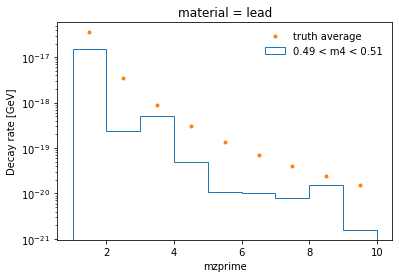

In [92]:
# normal call
output_distrib(exp_analysis_obj=my_exp_analysis, 
               binning_in='mzprime', #m4 or mzprime
               bins=9, 
               hist_range=[1, 10], 
               range_other_variable=[0.49, 0.51], 
               type_of_truth='average', #average or function
               material='lead')

histogram_entries = 18168
Total integral from vegas = 6.627929277779989e-20


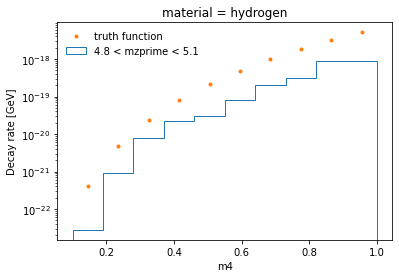

<function __main__.output_distrib(exp_analysis_obj, binning_in, bins, hist_range, range_other_variable, type_of_truth, material='lead')>

In [94]:
#with widgets, if it works for you
widgets.interact(output_distrib,
                 binning_in=widgets.RadioButtons(
                options=['m4', 'mzprime'],
                description='histogram in:',
                disabled=False,
            ),
          bins=widgets.IntSlider(min=1,
                                 max=50,
                                 step=1,
                                 value=10,
                                 description='number of bins:',
                                 continuous_update=False),
          hist_range=widgets.FloatRangeSlider(
                value=[0.1, 1],
                min=0,
                max=10.0,
                step=0.1,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
                description='histogram range'
            ),
          range_other_variable=widgets.FloatRangeSlider(
                value=[4.8, 5.1],
                min=0,
                max=10.0,
                step=0.01,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
                description='range other variable'
            ),
          material=widgets.RadioButtons(
                options=['hydrogen', 'oxygen', 'zinc', 'copper', 'iron', 'lead'],
                description='material:',
                disabled=False,
            ),
          type_of_truth=widgets.RadioButtons(
                options=['function', 'average'],
                description='truth plot:',
                disabled=False,
            ),
          exp_analysis_obj=widgets.fixed(my_exp_analysis))